# Hybrid Deep Learning Recommendation Engine

In this notebook, we develop several recommendation models for Movielens 100k dataset:
* First, we create a simple neural net that mimics SVD factorization.
* Second, we extend the basic net allowing for more complex interactions between user and item embeddings.
* Third, we use poster images and VGG16 net to recommend images based on poster similarity.
* Finally, we combine poster embeddings with the rating matrix to create a hybrid recommednation engine.

### Data
We use Movielens 100k dataset and enrich it with movie poster images. Scripts for poster scrapping and scrapped image URLs are available in the `tensor-house-data` repository.

In [1]:
import numpy as np 
import pandas as pd
from keras.utils import np_utils

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("ticks")
from tabulate import tabulate
from tqdm import tqdm_notebook as tqdm, trange

import glob
import ntpath
import cv2

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Dense, Input, Concatenate, Embedding, Dot, Flatten, Conv1D, Conv2D
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image as kimage

Using TensorFlow backend.


In [2]:
#
# Helper functions
#
def print_df(df, col_width = 10, rows = 10, max_cols = 10):
    def short_srt(x):
        return x if len(x) < col_width else x[:col_width-3] + "..."
    df_short = df.head(rows).applymap(lambda x: short_srt(str(x)))
    
    if len(df_short.columns) > max_cols:
        df_short = df_short.iloc[:, 0:max_cols-1]
        df_short['...'] = '...'
    
    print(tabulate(df_short, headers='keys', tablefmt='psql'))
    print(f'{len(df)} rows x {len(df.columns)} columns')
    
def plot_keras_training_hitory(history):
    plt.plot(history.history['loss']);
    plt.plot(history.history['val_loss']);
    plt.xlabel('Training epoch')
    plt.ylabel('Loss')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.grid(True)

# Step 1: Load Rating Data

In [3]:
base_data_path = '../../tensor-house-data/recommendations/movie-lens-100k/'
ratings = pd.read_csv(base_data_path + 'u.data.zip', sep='\t', compression='zip',
                      names=['user_id', 'item_id', 'rating', 'timestamp'])
n_users, n_items = ratings['user_id'].nunique(), ratings['item_id'].nunique()
print_df(ratings)

+----+-----------+-----------+----------+-------------+
|    |   user_id |   item_id |   rating |   timestamp |
|----+-----------+-----------+----------+-------------|
|  0 |       196 |       242 |        3 |   881250949 |
|  1 |       186 |       302 |        3 |   891717742 |
|  2 |        22 |       377 |        1 |   878887116 |
|  3 |       244 |        51 |        2 |   880606923 |
|  4 |       166 |       346 |        1 |   886397596 |
|  5 |       298 |       474 |        4 |   884182806 |
|  6 |       115 |       265 |        2 |   881171488 |
|  7 |       253 |       465 |        5 |   891628467 |
|  8 |       305 |       451 |        3 |   886324817 |
|  9 |         6 |        86 |        3 |   883603013 |
+----+-----------+-----------+----------+-------------+
100000 rows x 4 columns


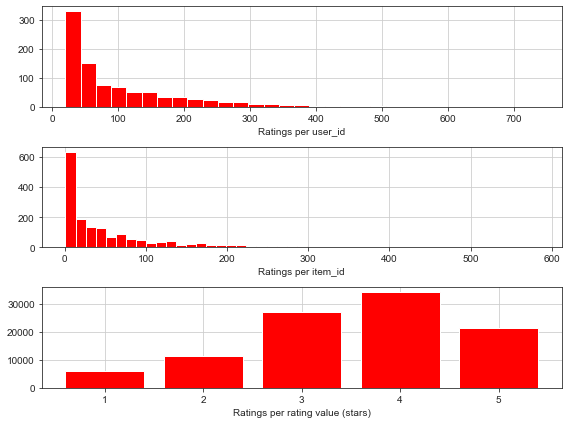

In [4]:
#
# Visualize the main statistics
#
fig, ax = plt.subplots(3, 1, figsize=(8, 6) )
for i, c in enumerate(['user_id', 'item_id']):
    sns.distplot(ratings.groupby(by=[c]).count().iloc[:, 0].values, kde=False, ax=ax[i], 
                 axlabel=f'Ratings per {c}', color='red', hist_kws=dict(alpha=1))
    ax[i].grid(True)
    
rating_frequencies = ratings.groupby(by=['rating']).count().iloc[:, 0]
ax[2].bar(rating_frequencies.index, rating_frequencies, color='red')
ax[2].grid(True)
ax[2].set_xlabel('Ratings per rating value (stars)')
plt.tight_layout()

# Step 2: Load Poster Data

In [17]:
image_paths = glob.glob('../../tensor-house-ext/recommendations/movie-lens-100k/imdb-posters/*.jpg')
print(f'Found [{len(image_paths)}] poster images for [{n_items}] movies')

images = [None]*n_items
for image_path in tqdm(image_paths):
    image = cv2.imread(image_path, 3)
    b,g,r = cv2.split(image)           # get b, g, r
    image = cv2.merge([r,g,b])         # switch it to r, g, b
    image = cv2.resize(image, (200, 200))
    movie_id = int(ntpath.basename(image_path)[:-4])
    images[movie_id-1] = image

Found [1605] poster images for [1682] movies


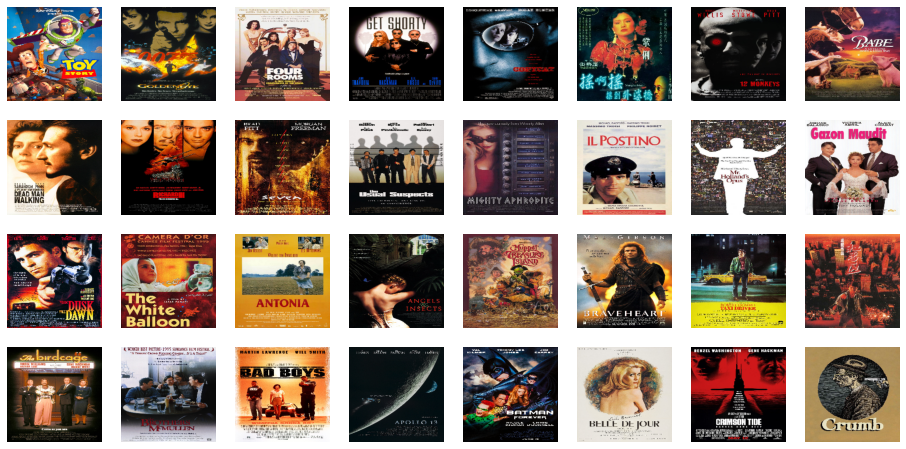

In [18]:
#
# Define helper functions for visualizing the 
# recommendations as posters and show poster examples
#
def show_image_grid(images, row_leaders=None, image_titles=None, leader_titles=None):
    n_row, n_col = images.shape[0:2]
    if row_leaders is not None:
        n_col += row_leaders.shape[1] + 1
    f, ax = plt.subplots(n_row, n_col, figsize=(2*n_col, 2*n_row))
    ax = np.atleast_2d(ax)
    for i in range(n_row):
        for j in range(n_col):
            if row_leaders is not None and j < row_leaders.shape[1]:
                if row_leaders[i ,j] is not None:
                    ax[i, j].imshow(row_leaders[i ,j])
                if leader_titles is not None:
                    ax[i, j].set_title(leader_titles[i, j])
                
            if row_leaders is not None and j == row_leaders.shape[1]:
                ax[i, j].arrow(0, 0, 1, 0, head_width=0.1, head_length=0.2, fc='k', ec='k')
                ax[i, j].set_ylim(-1, 1)
                
            if row_leaders is not None and j > row_leaders.shape[1]:
                index = (i, j - row_leaders.shape[1] - 1)
                if images[index] is not None:
                    ax[i, j].imshow(images[index])
                if image_titles is not None:
                        ax[i, j].set_title(image_titles[index])
            
            if row_leaders is None:
                index = (i, j)
                if images[index] is not None:
                    ax[i, j].imshow(images[index])
                if image_titles is not None:
                        ax[i, j].set_title(image_titles[index])
                    
            ax[i, j].set_axis_off() 

def show_recommedations(user_id, recommended_items, pred_ratings, k_historical = 8):
    recommendation_posters = np.atleast_2d(np.array(images)[recommended_items - 1])
    
    user_rated_movie_ids = ratings.query('user_id == @user_id').sort_values(by=['rating'], ascending=False)[['item_id', 'rating']].values
    print(f'User {user_id} has rated {user_rated_movie_ids.shape[0]} movies')
    user_rated_posters = np.atleast_2d(np.array(images)[user_rated_movie_ids[:k_historical, 0] - 1])
    user_rated_ratings = np.atleast_2d(user_rated_movie_ids[:k_historical, 1])

    show_image_grid(recommendation_posters, row_leaders = user_rated_posters, 
                    image_titles = np.atleast_2d(pred_ratings), leader_titles = user_rated_ratings)
            
show_image_grid(np.array(images[:32]).reshape(-1, 8, 200, 200, 3))

# Step 3: Recommendations Based on Ratings Using SVD-like Network

In this section, we create a simple network that models the iteraction between user and item vectors as a dot product. This basically mimics SVD factorization.

Epoch 1/16
20000/20000 [==============================] - 14s 704us/step - loss: 0.9197 - val_loss: 0.8972
Epoch 2/16
20000/20000 [==============================] - 13s 667us/step - loss: 0.8998 - val_loss: 0.8965
Epoch 3/16
20000/20000 [==============================] - 15s 735us/step - loss: 0.9005 - val_loss: 0.8972
Epoch 4/16
20000/20000 [==============================] - 13s 640us/step - loss: 0.9009 - val_loss: 0.9040
Epoch 5/16
20000/20000 [==============================] - 12s 616us/step - loss: 0.9012 - val_loss: 0.9046
Epoch 6/16
20000/20000 [==============================] - 12s 614us/step - loss: 0.9005 - val_loss: 0.8858
Epoch 7/16
20000/20000 [==============================] - 12s 612us/step - loss: 0.8186 - val_loss: 0.7950
Epoch 8/16
20000/20000 [==============================] - 12s 609us/step - loss: 0.7563 - val_loss: 0.7716
Epoch 9/16
20000/20000 [==============================] - 12s 605us/step - loss: 0.7347 - val_loss: 0.7640
Epoch 10/16
20000/20000 [============

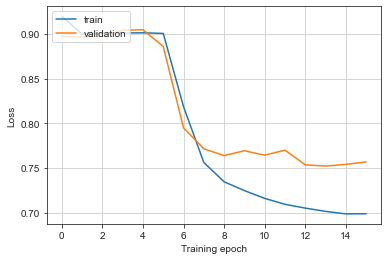

In [23]:
x, y = ratings[['user_id', 'item_id']].values, ratings[['rating']].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

#
# Model specification
#
embedding_dim = 4

input_user = Input(shape=(1,))
input_item = Input(shape=(1,))

embedding_user = Embedding(input_dim=n_users + 1, output_dim=embedding_dim)(input_user)
embedding_item = Embedding(input_dim=n_items + 1, output_dim=embedding_dim)(input_item)

combined = Dot(axes=2)([embedding_user, embedding_item])

score = Dense(1, activation='linear')(combined)

model_sgd = Model(inputs=[input_user, input_item], outputs=score)

#
# Model training
#
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model_sgd.compile(optimizer=opt, loss='mean_absolute_error') 
history_sgd = model_sgd.fit([x_train[:, 0], x_train[:, 1]], y_train, 
                    batch_size=4, epochs=16, verbose=1, 
                    validation_data=([x_test[:, 0], x_test[:, 1]], y_test)) 

plot_keras_training_hitory(history_sgd)

User 29 has rated 34 movies
User 118 has rated 71 movies
User 304 has rated 26 movies


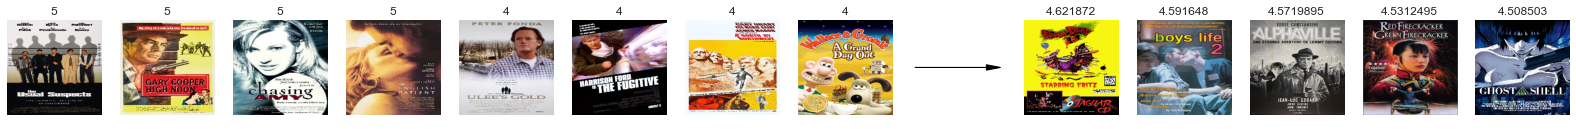

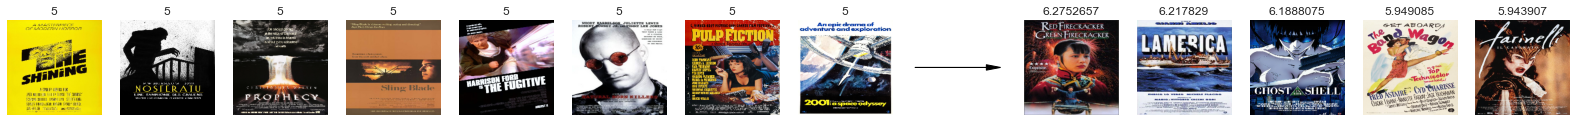

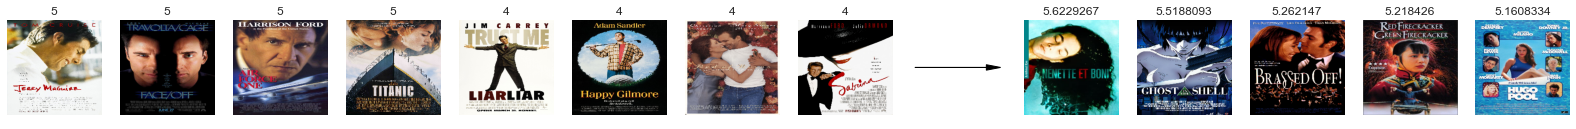

In [24]:
#
# Visualize example recommendations
#
def recommend_for_user(model, user_id, k):
    x1, x2 = np.repeat(user_id, n_items), np.arange(n_items) + 1
    ratings = model.predict([x1, x2]).ravel()
    top_k_indexes = ratings.argsort()[-k:][::-1]
    return x2[top_k_indexes], ratings[top_k_indexes]

for user_id in [29, 118, 304]:
    recommended_items, pred_ratings = recommend_for_user(model_sgd, user_id, k = 5)
    show_recommedations(user_id, recommended_items, pred_ratings, k_historical = 8)

# Step 4: Recommendations Based on Ratings Using a Deep Neural Net

In this section, we extend the basic SVD-like network with higher capacity layers to model more complex interactions between user and item embeddings.

Epoch 1/20
20000/20000 [==============================] - 15s 756us/step - loss: 0.7898 - root_mean_squared_error: 1.0219 - val_loss: 0.7406 - val_root_mean_squared_error: 0.9661
Epoch 2/20
20000/20000 [==============================] - 15s 726us/step - loss: 0.7302 - root_mean_squared_error: 0.9586 - val_loss: 0.7276 - val_root_mean_squared_error: 0.9682
Epoch 3/20
20000/20000 [==============================] - 15s 755us/step - loss: 0.7098 - root_mean_squared_error: 0.9484 - val_loss: 0.7340 - val_root_mean_squared_error: 0.9864
Epoch 4/20
20000/20000 [==============================] - 17s 828us/step - loss: 0.6938 - root_mean_squared_error: 0.9419 - val_loss: 0.7143 - val_root_mean_squared_error: 0.9697
Epoch 5/20
20000/20000 [==============================] - 16s 822us/step - loss: 0.6824 - root_mean_squared_error: 0.9391 - val_loss: 0.7190 - val_root_mean_squared_error: 0.9834
Epoch 6/20
20000/20000 [==============================] - 16s 802us/step - loss: 0.6735 - root_mean_squar

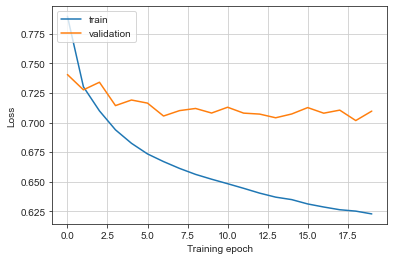

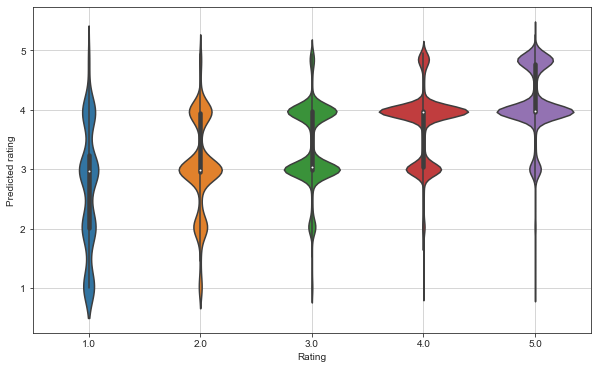

In [29]:
x, y = ratings[['user_id', 'item_id']].values, ratings[['rating']].values

n_users, n_items = len(np.unique(x[:, 0])), len(np.unique(x[:, 1]))

def recommender_model_ratings(embedding_dim):
    input_user = Input(shape=(1,))
    input_item = Input(shape=(1,))

    embedding_user = Embedding(input_dim=n_users + 1, output_dim=embedding_dim)(input_user)
    embedding_item = Embedding(input_dim=n_items + 1, output_dim=embedding_dim)(input_item)

    e1 = Flatten()(embedding_user)
    e2 = Flatten()(embedding_item)

    combined = Concatenate(axis=1)([e1, e2])
    combined2 = Dense(32, activation='relu')(combined)
    combined3 = Dense(16, activation='relu')(combined2)

    rating = Dense(1, activation='linear')(combined3)

    model = Model(inputs=[input_user, input_item], outputs=rating)
    
    return model

def train_model_ratings(random_state = 42):
    #
    # Data preparation
    #
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=random_state)
    x1_train, x2_train = x_train[:, 0], x_train[:, 1]
    x1_test, x2_test = x_test[:, 0], x_test[:, 1]

    #
    # Model training
    #
    model = recommender_model_ratings(embedding_dim = 4)
    model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[tf.keras.metrics.RootMeanSquaredError()]) 
    history = model.fit([x1_train, x2_train], y_train, batch_size=4, epochs=20, validation_data=([x1_test, x2_test], y_test), verbose=1)
    
    return model, history, x_train, x_test, y_train, y_test

model_rating, history_rating, x_train, x_test, y_train, y_test = train_model_ratings()

plot_keras_training_hitory(history_rating)

y_test_hat = model_rating.predict([x_test[:, 0], x_test[:, 1]])
plot_data = pd.DataFrame(np.hstack([y_test, y_test_hat]), columns=['Rating', 'Predicted rating'])
fig, ax = plt.subplots(1, figsize=(10, 6))
sns.violinplot(data=plot_data, x = "Rating", y = "Predicted rating", ax=ax)
plt.grid(True)

User 29 has rated 34 movies
User 118 has rated 71 movies
User 304 has rated 26 movies


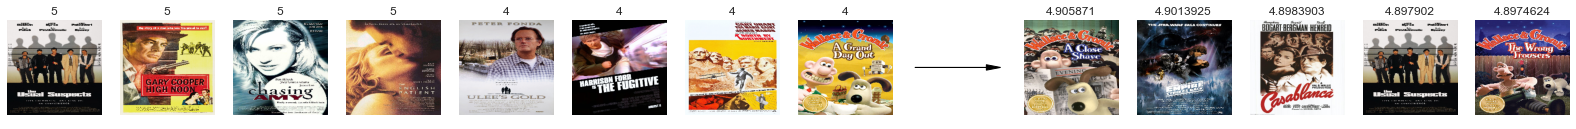

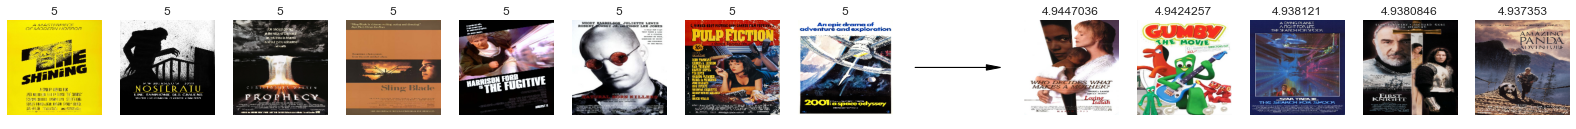

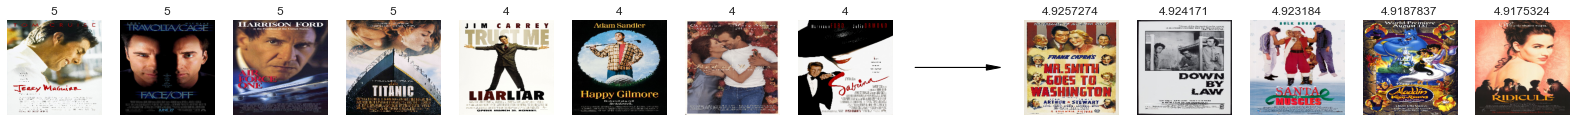

In [30]:
#
# Visualize example recommendations
#
def recommend_for_user(model, user_id, k):
    x1, x2 = np.repeat(user_id, n_items), np.arange(n_items) + 1
    ratings = model.predict([x1, x2]).ravel()
    top_k_indexes = ratings.argsort()[-k:][::-1]
    return x2[top_k_indexes], ratings[top_k_indexes]

for user_id in [29, 118, 304]:
    recommended_items, pred_ratings = recommend_for_user(model_rating, user_id, k = 5)
    show_recommedations(user_id, recommended_items, pred_ratings, k_historical = 8)

# Step 5: Recommendations Based on Poster Images (Non-personalized)

We compute 512-dimensional poster embeddings using VGG19 network and make recommendations based on the nearest neighbors in the embedding space.

In [31]:
#
# Computer poster embedding vectors
#
image_tensors = [None] * n_items
for i in range(n_items):
    if images[i] is not None:
        image_tensors[i] = images[i][tf.newaxis, :]     # shape -> (batch_size, h, w, d)
        image_tensors[i] = preprocess_input(image_tensors[i])   
    
model = tf.keras.applications.VGG19(include_top=False, pooling='avg', weights='imagenet')

prediction = [0]*n_items
poster_embeddings = np.zeros([n_items, 512])
for i in tqdm(range(n_items)):
    if image_tensors[i] is not None:
        prediction[i] = model.predict(image_tensors[i]).ravel()
        poster_embeddings[i, :] = prediction[i] 

In [32]:
#
# Compute the poster similarity matrix
#
similarity_posters = poster_embeddings.dot(poster_embeddings.T)
norms = np.array([np.sqrt(np.diagonal(similarity_posters)) + 0.001])
similarity_posters = similarity_posters / norms / norms.T

def recommend_content(movie_id, k):
    return similarity_posters[movie_id-1].argsort()[-k:][::-1]

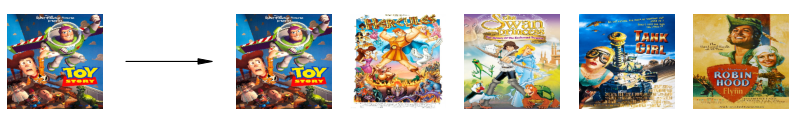

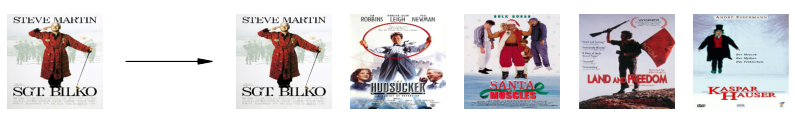

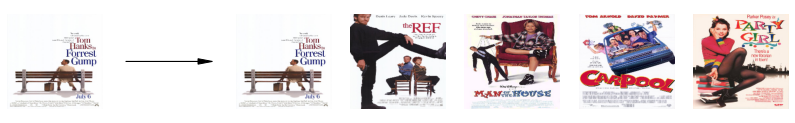

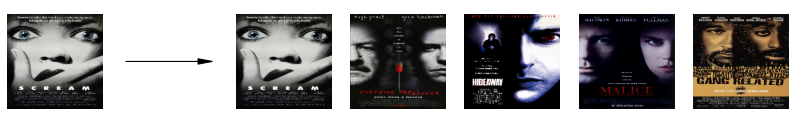

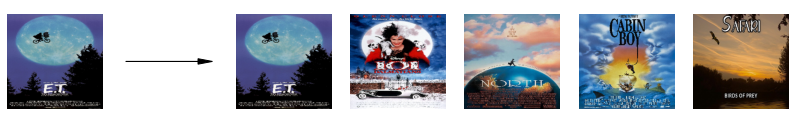

In [33]:
for movie_id in [1, 105, 69, 288, 423]: 
    input_poster = np.array([[ np.array(images)[movie_id-1] ]])
    recommendations = np.atleast_2d(recommend_content(movie_id, 5))
    show_image_grid(np.array(images)[recommendations], input_poster)

# Step 6: Recommendations Based on Both Ratings and Posters (Hybrid Recommender)

In this section, we combine user, item, and poster embeddings in one three-tower neural net. This does not help to improve the accuracy becasue posters apparently do not carry an informative signal about the movie content, but a similar approach can work much better in eCommerce applications where product images contain useful information about styles. 

It is also possible to predict ratings based only on posters (we can remove `e2` tensor from the concatenation in the model below). This will enable recommendations for new movies that do not have ratings yet.

Epoch 1/16
10000/10000 [==============================] - 8s 806us/step - loss: 0.8022 - root_mean_squared_error: 1.0468 - val_loss: 0.7522 - val_root_mean_squared_error: 0.9844
Epoch 2/16
10000/10000 [==============================] - 8s 800us/step - loss: 0.7351 - root_mean_squared_error: 0.9587 - val_loss: 0.7535 - val_root_mean_squared_error: 0.9944
Epoch 3/16
10000/10000 [==============================] - 8s 801us/step - loss: 0.7189 - root_mean_squared_error: 0.9484 - val_loss: 0.7346 - val_root_mean_squared_error: 0.9527
Epoch 4/16
10000/10000 [==============================] - 8s 795us/step - loss: 0.7071 - root_mean_squared_error: 0.9392 - val_loss: 0.7276 - val_root_mean_squared_error: 0.9704
Epoch 5/16
10000/10000 [==============================] - 8s 789us/step - loss: 0.6958 - root_mean_squared_error: 0.9333 - val_loss: 0.7135 - val_root_mean_squared_error: 0.9558
Epoch 6/16
10000/10000 [==============================] - 8s 780us/step - loss: 0.6846 - root_mean_squared_err

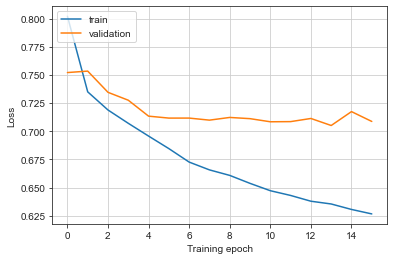

In [38]:
x, y = ratings[['user_id', 'item_id']].values, ratings[['rating']].values

def recommender_model_hybrid(embedding_dim):
    input_user = Input(shape=(1,))
    input_item = Input(shape=(1,))
    input_poster = Input(shape=(512,))

    embedding_user = Embedding(input_dim=n_users + 1, output_dim=embedding_dim)(input_user)
    embedding_item = Embedding(input_dim=n_items + 1, output_dim=embedding_dim)(input_item)
    
    e1 = Flatten()(embedding_user)
    e2 = Flatten()(embedding_item)
    
    e3c = Dense(4, activation='relu')(input_poster)

    combined = Concatenate(axis=1)([e1, e2, e3c])
    combined2 = Dense(32, activation='relu')(combined)
    combined3 = Dense(16, activation='relu')(combined2)

    rating = Dense(1, activation='linear')(combined3)

    model = Model(inputs=[input_user, input_item, input_poster], outputs=rating)
    
    return model

def train_model_hybrid(random_state = 42):
    #
    # Data preparation
    #
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=random_state)
        
    x1_train, x2_train = x_train[:, 0].astype(int), x_train[:, 1].astype(int)
    x3_train = poster_embeddings[x2_train - 1]
    x1_test, x2_test = x_test[:, 0].astype(int), x_test[:, 1].astype(int)
    x3_test = poster_embeddings[x2_test - 1]

    #
    # Model training
    #
    model = recommender_model_hybrid(embedding_dim = 4)
    model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[tf.keras.metrics.RootMeanSquaredError()]) 
    history = model.fit([x1_train, x2_train, x3_train], 
                        y_train, 
                        batch_size=8, 
                        epochs=16, 
                        verbose=1,
                        validation_data=([x1_test, x2_test, x3_test], y_test))
    
    return model, history

model_hybrid, history_hybrid = train_model_hybrid()

plot_keras_training_hitory(history_hybrid)

User 29 has rated 34 movies
User 118 has rated 71 movies
User 304 has rated 26 movies


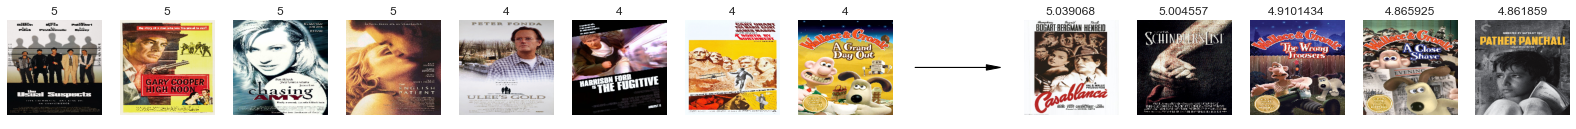

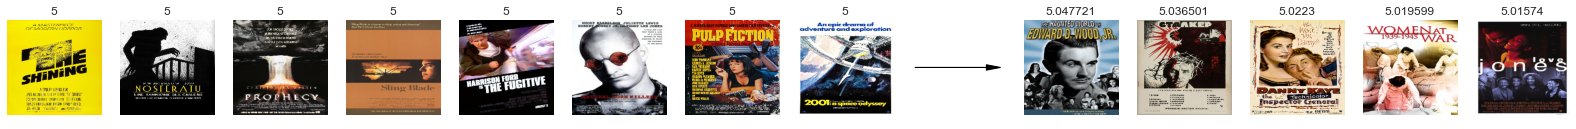

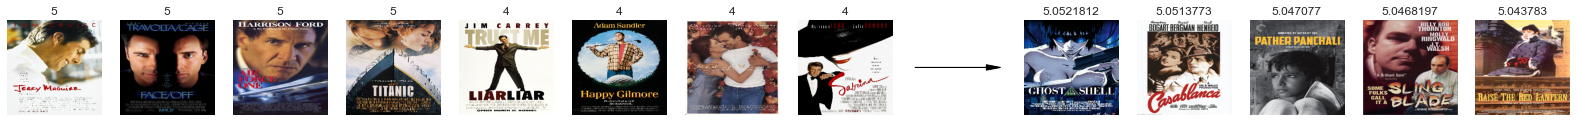

In [39]:
def recommend_for_user_hybrid(model, user_id, k):
    x1, x2 = np.repeat(user_id, n_items), np.arange(n_items) + 1
    x3 = poster_embeddings[x2 - 1]
    ratings = model.predict([x1, x2, x3]).ravel()
    top_k_indexes = ratings.argsort()[-k:][::-1]
    return x2[top_k_indexes], ratings[top_k_indexes]

for user_id in [29, 118, 304]:
    recommended_items, pred_ratings = recommend_for_user_hybrid(model_hybrid, user_id, k = 5)
    show_recommedations(user_id, recommended_items, pred_ratings, k_historical = 8)

# Step 7: Recommendation Based on Ratings and Screenshots

In [5]:
image_paths = glob.glob('../../tensor-house-data/recommendations/movie-lens-100k/imdb-thumbnails-20/*.jpg')
print(f'Found [{len(image_paths)}] images for [{n_items}] movies')

image_thumbnails = [[] for i in range(n_items)]
for image_path in tqdm(image_paths):
    image = cv2.imread(image_path, 3)
    b,g,r = cv2.split(image)           # get b, g, r
    image = cv2.merge([r,g,b])         # switch it to r, g, b
    image = cv2.resize(image, (200, 200))
    movie_id = int(ntpath.basename(image_path)[:-4].split('_')[0])
    image_thumbnails[movie_id-1].append(image)

Found [26731] images for [1682] movies


In [6]:
#
# Computer image embedding vectors
#
n_thum_per_movie = 20
thumbnail_tensors = [[None for j in range(n_thum_per_movie)] for i in range(n_items)]
for i in tqdm(range(n_items)):
    for j, image in enumerate(image_thumbnails[i]):
        image_tensor = image[tf.newaxis, :] # shape -> (batch_size, h, w, d)
        thumbnail_tensors[i][j] = preprocess_input(image_tensor)     

    
model = tf.keras.applications.VGG19(include_top=False, pooling='avg', weights='imagenet')

thumbnail_embeddings = np.zeros([n_items, n_thum_per_movie, 512])
for i in tqdm(range(n_items)):
    for j, tensor in enumerate(thumbnail_tensors[i]):
        if tensor is not None:
            thumbnail_embeddings[i, j, :] = model.predict(tensor).ravel()

Epoch 1/16
10000/10000 [==============================] - 38s 4ms/step - loss: 0.8627 - root_mean_squared_error: 1.1273 - val_loss: 0.7964 - val_root_mean_squared_error: 1.0372
Epoch 2/16
10000/10000 [==============================] - 27s 3ms/step - loss: 0.7878 - root_mean_squared_error: 1.0229 - val_loss: 0.8023 - val_root_mean_squared_error: 1.0491
Epoch 3/16
10000/10000 [==============================] - 28s 3ms/step - loss: 0.7723 - root_mean_squared_error: 1.0112 - val_loss: 0.7738 - val_root_mean_squared_error: 1.0156
Epoch 4/16
10000/10000 [==============================] - 26s 3ms/step - loss: 0.7611 - root_mean_squared_error: 1.0042 - val_loss: 0.7673 - val_root_mean_squared_error: 1.0164
Epoch 5/16
10000/10000 [==============================] - 24s 2ms/step - loss: 0.7518 - root_mean_squared_error: 0.9978 - val_loss: 0.7557 - val_root_mean_squared_error: 1.0068
Epoch 6/16
10000/10000 [==============================] - 28s 3ms/step - loss: 0.7439 - root_mean_squared_error: 0.

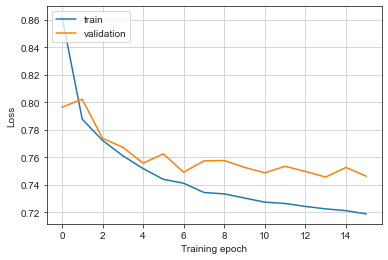

In [14]:
x, y = ratings[['user_id', 'item_id']].values, ratings[['rating']].values

def recommender_model_hybrid2(embedding_dim):
    input_user = Input(shape=(1,))
    input_item = Input(shape=(1,))
    input_image = Input(shape=(n_thum_per_movie, 512,))

    embedding_user = Embedding(input_dim=n_users + 1, output_dim=embedding_dim)(input_user)
    embedding_item = Embedding(input_dim=n_items + 1, output_dim=embedding_dim)(input_item)
    
    e1 = Flatten()(embedding_user)
    e2 = Flatten()(embedding_item)
    
    e3c = Dense(8, activation='relu')(input_image)
    e3c2 = Flatten()(e3c)
    e3c3 = Dense(4, activation='relu')(e3c2)

    combined = Concatenate(axis=1)([e1, e3c3])
    combined2 = Dense(32, activation='relu')(combined)
    combined3 = Dense(16, activation='relu')(combined2)

    rating = Dense(1, activation='linear')(combined3)

    model = Model(inputs=[input_user, input_item, input_image], outputs=rating)
    
    return model

def train_model_hybrid2(random_state = 42):
    #
    # Data preparation
    #
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=random_state)
        
    x1_train, x2_train = x_train[:, 0].astype(int), x_train[:, 1].astype(int)
    x3_train = thumbnail_embeddings[x2_train - 1]
    x1_test, x2_test = x_test[:, 0].astype(int), x_test[:, 1].astype(int)
    x3_test = thumbnail_embeddings[x2_test - 1]

    #
    # Model training
    #
    model = recommender_model_hybrid2(embedding_dim = 4)
    model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[tf.keras.metrics.RootMeanSquaredError()]) 
    history = model.fit([x1_train, x2_train, x3_train], 
                        y_train, 
                        batch_size=8, 
                        epochs=16, 
                        verbose=1,
                        validation_data=([x1_test, x2_test, x3_test], y_test))
    
    return model, history

model_hybrid2, history_hybrid2 = train_model_hybrid2()

plot_keras_training_hitory(history_hybrid2)

User 29 has rated 34 movies
User 118 has rated 71 movies
User 304 has rated 26 movies


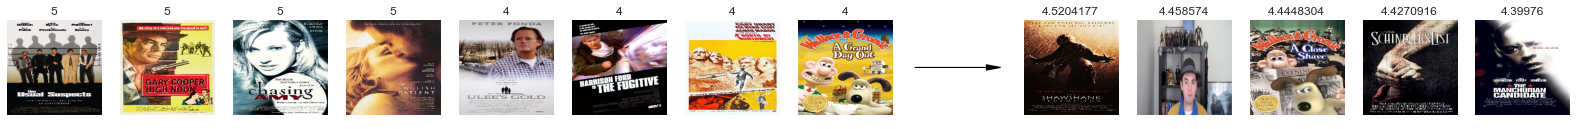

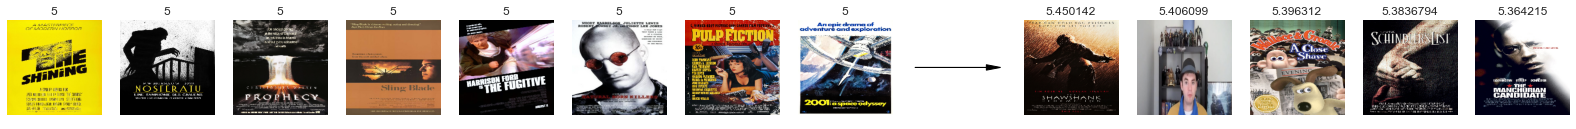

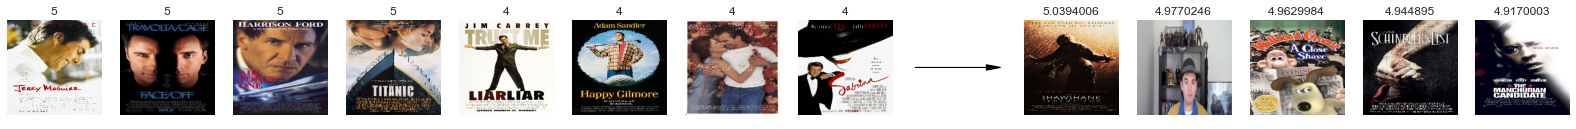

In [20]:
def recommend_for_user_hybrid(model, user_id, k):
    x1, x2 = np.repeat(user_id, n_items), np.arange(n_items) + 1
    x3 = thumbnail_embeddings[x2 - 1]
    ratings = model.predict([x1, x2, x3]).ravel()
    top_k_indexes = ratings.argsort()[-k:][::-1]
    return x2[top_k_indexes], ratings[top_k_indexes]

for user_id in [29, 118, 304]:
    recommended_items, pred_ratings = recommend_for_user_hybrid(model_hybrid2, user_id, k = 5)
    show_recommedations(user_id, recommended_items, pred_ratings, k_historical = 8)